## Carvana Notebook


This notebook was created to solve Carvana's image masking challenge:
<br>https://www.kaggle.com/c/carvana-image-masking-challenge/submit
<br>
<br>Credit and inspiration to Bruno G. do Amaral's notebook on the same:
<br>https://www.kaggle.com/bguberfain/naive-keras

### Package setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from os.path import join
from skimage.io import imread
from skimage.transform import downscale_local_mean
from tqdm.notebook import tqdm

import tensorflow as tf
from sklearn.model_selection import train_test_split

Looking at the train_masks CSV, we can see that the images have named jpeg files. The name consists of an identifier for the model type, concatenated with an index for the viewing angle. There are 16 viewing angles in total.

Masks will have to be segmented by each of the viewing angles.

In [2]:
df_mask = pd.read_csv('./train_masks.csv/train_masks.csv', usecols=['img'])
df_mask.head()

,img
0,00087a6bd4dc_01.jpg
1,00087a6bd4dc_02.jpg
2,00087a6bd4dc_03.jpg
3,00087a6bd4dc_04.jpg
4,00087a6bd4dc_05.jpg


### Identifying masks per Car

In [3]:
#Extract each car model's identifier
ids_train = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

#Indexing the number of viewing angles
imgs_idx = list(range(1, 17))

In [4]:
#creating lambda functions to get image file names, and masks file names
load_img = lambda im, idx: imread(join('train', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join('train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))
#Resizing the original images/masks and downscale by x4 x4. only grayscale required for simple mask
resize = lambda im: downscale_local_mean(im, (4,4) if im.ndim==2 else (4,4,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))

Now we are ready to load our image data into X, our training set. we will first load for the index=1, the forward facing angle of the car. 3 channels for colours are created, RGB. Then, for each colour channel, the image intensity value, image mean value, as well as the image standard deviation

In [5]:
num_train = 48  # len(ids_train), can be modified as memory allows

# Load data for position id=1
X = np.empty((num_train, 320, 480, 12), dtype=np.float32)
y = np.empty((num_train, 320, 480, 1), dtype=np.float32)
with tqdm(total=num_train) as bar:
    idx = 1 # Rotation index, with images segmanted into each of the 16 rotation indexes
    for i, img_id in enumerate(ids_train[:num_train]):
        imgs_id = [resize(load_img(img_id, j)) for j in imgs_idx]
        # Input is image + mean image per channel + std image per channel
        X[i, ..., :9] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
        y[i] = resize(np.expand_dims(load_mask(img_id, idx), 2)) / 255.
        del imgs_id # Free memory
        bar.update()

In [251]:
# train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

To accelerate the learning of the masks, 3 more channels were added, based on the existing masks' mean, standard deviation, and minimum values of the masks. These are also input into the CNN, giving a total of 12 channels. 

In [252]:
y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train_min = y_train.min(axis=0)

y_features = np.concatenate([y_train_mean, y_train_std, y_train_min], axis=2)

In [253]:
X_mean = X_train.mean(axis=(0,1,2), keepdims=True)
X_std = X_train.std(axis=(0,1,2), keepdims=True)

X_train -= X_mean
X_train /= X_std

X_val -= X_mean
X_val /= X_std

X_train[:, ..., -3:] = y_features
X_val[:, ..., -3:] = y_features

<ipython-input-253-ad0235b54061>:5: RuntimeWarning: invalid value encountered in true_divide
  X_train /= X_std
<ipython-input-253-ad0235b54061>:8: RuntimeWarning: invalid value encountered in true_divide
  X_val /= X_std


In [254]:
# Create simple model, 3x3 filters, with 3 of them, on an input layer of the 320*480 picture
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from keras.models import Model
import keras.backend as K

inp = Input((320, 480, 12))
conv1 = Conv2D(12, 3, activation='relu', padding='same')(inp)
max1 = MaxPooling2D(2)(conv1)
conv2 = Conv2D(12, 3, activation='relu', padding='same')(max1)
max2 = MaxPooling2D(2)(conv2)
conv3 = Conv2D(12, 3, activation='relu', padding='same')(max2)

deconv3 = Conv2DTranspose(12, 3, strides=4, activation='relu', padding='same')(conv3)
deconv2 = Conv2DTranspose(12, 3, strides=2, activation='relu', padding='same')(conv2)

deconvs = concatenate([conv1, deconv2, deconv3])

out = Conv2D(1, 7, activation='sigmoid', padding='same')(deconvs)

model = Model(inp, out)
model.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 320, 480, 12 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 320, 480, 12) 1308        input_19[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 160, 240, 12) 0           conv2d_72[0][0]                  
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 160, 240, 12) 1308        max_pooling2d_36[0][0]           
______________________________________________________________________________________

In [255]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

model.compile(Adam(lr=1e-3), dice_loss, metrics=['accuracy', dice_coef])

In [256]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=5, verbose=1)


Epoch 1/20
8/8 [==============================] - 11s 1s/step - loss: -0.3659 - accuracy: 0.7893 - dice_coef: 0.3732 - val_loss: -0.5459 - val_accuracy: 0.8042 - val_dice_coef: 0.5459
Epoch 2/20
8/8 [==============================] - 11s 1s/step - loss: -0.5630 - accuracy: 0.7790 - dice_coef: 0.5653 - val_loss: -0.6459 - val_accuracy: 0.7961 - val_dice_coef: 0.6459
Epoch 3/20
8/8 [==============================] - 11s 1s/step - loss: -0.6335 - accuracy: 0.7997 - dice_coef: 0.6356 - val_loss: -0.6647 - val_accuracy: 0.7980 - val_dice_coef: 0.6647
Epoch 4/20
8/8 [==============================] - 11s 1s/step - loss: -0.6654 - accuracy: 0.8137 - dice_coef: 0.6654 - val_loss: -0.6735 - val_accuracy: 0.8019 - val_dice_coef: 0.6735
Epoch 5/20
8/8 [==============================] - 11s 1s/step - loss: -0.6783 - accuracy: 0.8205 - dice_coef: 0.6747 - val_loss: -0.6843 - val_accuracy: 0.8027 - val_dice_coef: 0.6843
Epoch 6/20
8/8 [==============================] - 11s 1s/step - loss: -0.7043 - 

In [258]:
#save model in case of transfer learning
model.save('models/model16.hdf5',include_optimizer=False)

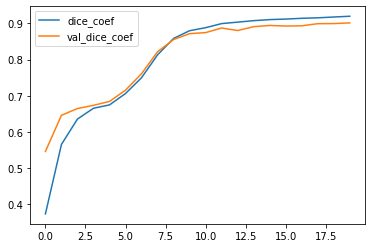

In [259]:
#recording history to see if overfitting is happening
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
plt.savefig('./ppt/dice_coeff_16.jpg')

Text(0.5, 1.0, 'y_pred')

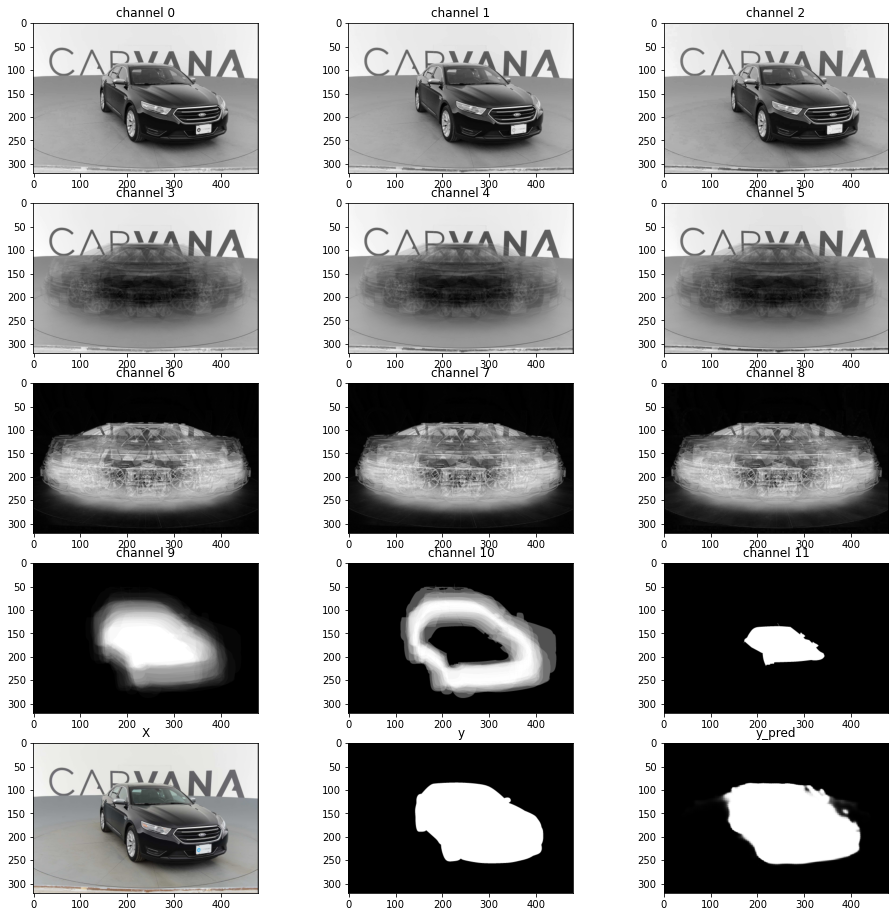

In [260]:
#Display for each of the input channels for the final layer
idx = 
x = X_val[idx]

fig, ax = plt.subplots(5,3, figsize=(16, 16))
ax = ax.ravel()

cmaps = ['Reds', 'Greens', 'Blues']
for i in range(x.shape[-1]):
    ax[i].imshow(x[...,i], cmap='gray') #cmaps[i%3])
    ax[i].set_title('channel {}'.format(i))

ax[-3].imshow((x[...,:3] * X_std[0,...,:3] + X_mean[0,...,:3]) / 255.)
ax[-3].set_title('X')

ax[-2].imshow(y_val[idx,...,0], cmap='gray')
ax[-2].set_title('y')

y_pred = model.predict(x[None]).squeeze()
ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred')

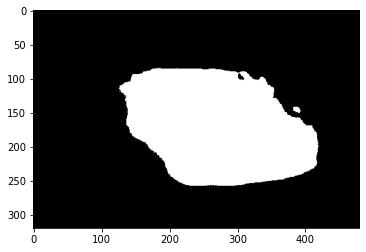

In [261]:
plt.imshow(y_pred > 0.5, cmap='gray')

In [262]:
plt.imsave('./final_mask/trained_mask_16.jpg',y_pred > 0.5,format='jpg',cmap='gray')

In [263]:
# set the base width of the result
img = Image.open('./final_mask/trained_mask_16.jpg')
# resize image and save
img = img.resize((1918,1280), Image.ANTIALIAS)
img.save('./final_mask/trained_mask_16_full.jpg') 

In [7]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


In [8]:
img = imread('./final_mask/trained_mask_01_full.jpg',as_gray=True)
img.shape
rle_1=rle_encode(img)

In [21]:
img1 = imread('./final_mask/trained_mask_01_full.jpg')
rle_1=rle_encode(img1)
img2 = imread('./final_mask/trained_mask_02_full.jpg')
rle_2=rle_encode(img2)
img3 = imread('./final_mask/trained_mask_03_full.jpg')
rle_3=rle_encode(img3)
img4 = imread('./final_mask/trained_mask_04_full.jpg')
rle_4=rle_encode(img4)
img5 = imread('./final_mask/trained_mask_05_full.jpg')
rle_5=rle_encode(img5)
img6 = imread('./final_mask/trained_mask_06_full.jpg')
rle_6=rle_encode(img6)
img7 = imread('./final_mask/trained_mask_07_full.jpg')
rle_7=rle_encode(img7)
img8 = imread('./final_mask/trained_mask_08_full.jpg')
rle_8=rle_encode(img8)
img9 = imread('./final_mask/trained_mask_09_full.jpg')
rle_9=rle_encode(img9)
img10 = imread('./final_mask/trained_mask_10_full.jpg')
rle_10=rle_encode(img10)
img11 = imread('./final_mask/trained_mask_11_full.jpg')
rle_11=rle_encode(img11)
img12 = imread('./final_mask/trained_mask_12_full.jpg')
rle_12=rle_encode(img12)
img13 = imread('./final_mask/trained_mask_13_full.jpg')
rle_13=rle_encode(img13)
img14 = imread('./final_mask/trained_mask_14_full.jpg')
rle_14=rle_encode(img14)
img15 = imread('./final_mask/trained_mask_15_full.jpg')
rle_15=rle_encode(img15)
img16 = imread('./final_mask/trained_mask_16_full.jpg')
rle_16=rle_encode(img16)

In [22]:
df_submission = pd.read_csv('./sample_submission.csv/sample_submission.csv')

In [23]:
range(df_submission.shape[0])

range(0, 100064)

In [24]:
rle_list=['' for x in range(df_submission.shape[0])]

In [25]:
rle_1 = ''.join(str(e)+' ' for e in rle_1)

In [26]:
rle_2 = ''.join(str(e)+' ' for e in rle_2)
rle_3 = ''.join(str(e)+' ' for e in rle_3)
rle_4 = ''.join(str(e)+' ' for e in rle_4)
rle_5 = ''.join(str(e)+' ' for e in rle_5)
rle_6 = ''.join(str(e)+' ' for e in rle_6)
rle_7 = ''.join(str(e)+' ' for e in rle_7)
rle_8 = ''.join(str(e)+' ' for e in rle_8)
rle_9 = ''.join(str(e)+' ' for e in rle_9)
rle_10 = ''.join(str(e)+' ' for e in rle_10)
rle_11 = ''.join(str(e)+' ' for e in rle_11)
rle_12 = ''.join(str(e)+' ' for e in rle_12)
rle_13 = ''.join(str(e)+' ' for e in rle_13)
rle_14 = ''.join(str(e)+' ' for e in rle_14)
rle_15 = ''.join(str(e)+' ' for e in rle_15)
rle_16 = ''.join(str(e)+' ' for e in rle_16)

In [27]:
for i in range(df_submission.shape[0]):
    if i%16==0:
        rle_list[i]=rle_1
    elif i%16==1:
        rle_list[i]=rle_2
    elif i%16==2:
        rle_list[i]=rle_3
    elif i%16==3:
        rle_list[i]=rle_4
    elif i%16==4:
        rle_list[i]=rle_5
    elif i%16==5:
        rle_list[i]=rle_6
    elif i%16==6:
        rle_list[i]=rle_7
    elif i%16==7:
        rle_list[i]=rle_8
    elif i%16==8:
        rle_list[i]=rle_9
    elif i%16==9:
        rle_list[i]=rle_10
    elif i%16==10:
        rle_list[i]=rle_11
    elif i%16==11:
        rle_list[i]=rle_12
    elif i%16==12:
        rle_list[i]=rle_13
    elif i%16==13:
        rle_list[i]=rle_14
    elif i%16==14:
        rle_list[i]=rle_15
    elif i%16==15:
        rle_list[i]=rle_16

In [28]:
df_submission.rle_mask=rle_list

In [29]:
df_submission.head(20)

,img,rle_mask
0,0004d4463b50_01.jpg,1797961 9 1798297 9 1798489 9 1804051 9 180424...
1,0004d4463b50_02.jpg,1803931 24 1803979 24 1809685 24 1809733 24 18...
2,0004d4463b50_03.jpg,1798600 9 1803931 24 1804354 9 1809685 24 1810...
3,0004d4463b50_04.jpg,1798051 3 1798057 576 1798642 15 1798666 189 1...
4,0004d4463b50_05.jpg,1797640 9 1797712 9 1797865 9 1798033 15 17985...
5,0004d4463b50_06.jpg,1797448 9 1797577 9 1797685 12 1797808 9 17980...
6,0004d4463b50_07.jpg,1797562 12 1797754 12 1798648 9 1803310 6 1803...
7,0004d4463b50_08.jpg,1797376 9 1797448 18 1797496 9 1798657 9 18031...
8,0004d4463b50_09.jpg,1935553 3 1935568 3 1936033 3 1936051 3 193605...
9,0004d4463b50_10.jpg,1797601 9 1803355 12 1809109 9 1814863 3 18205...


In [30]:
df_submission.to_csv('./submission/submission.csv',index=False)